# Nuclei segmentation

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import gzip

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
from scipy import ndimage

plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and opera

## Load the data

In [15]:
adata = st.io.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz', 'data/SS200000135IL-D1.ssDNA.tif', scale=0.5, scale_unit='um')
adata

AnnData object with n_obs × n_vars = 2001 × 2001
    uns: '__type', 'pp', 'spatial'
    layers: 'nuclei', 'spliced', 'unspliced'

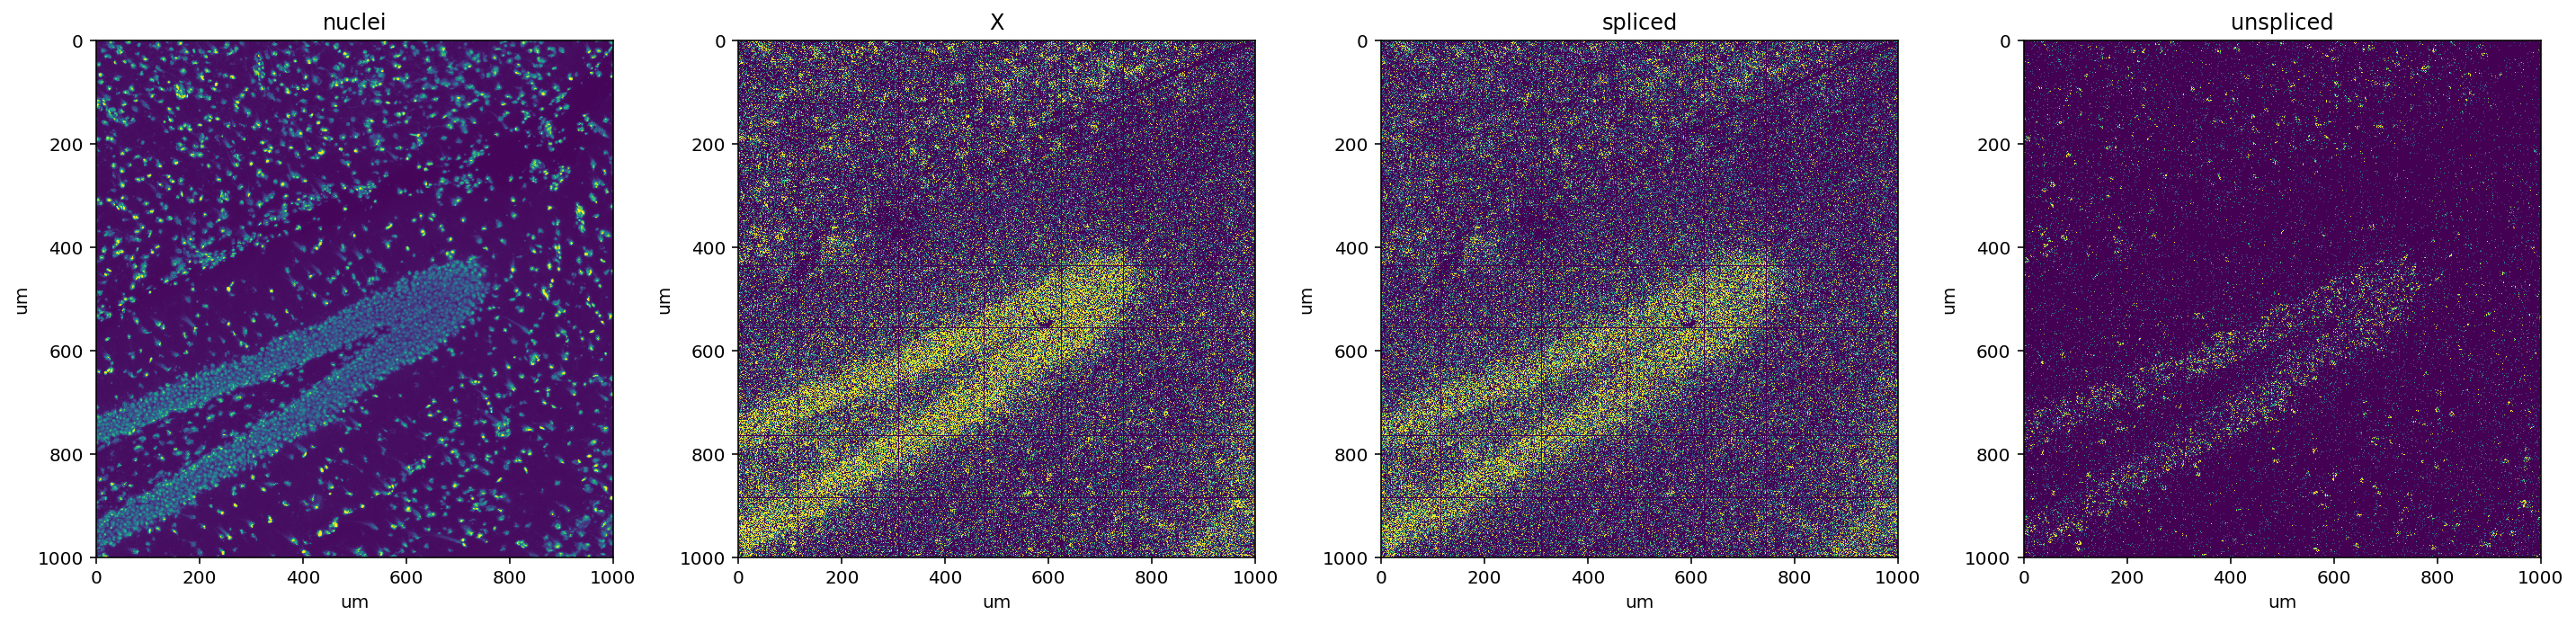

In [44]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclei', ax=axes[0])
axes[0].set_title('nuclei')
st.pl.imshow(adata, 'X', ax=axes[1], vmax=5)
st.pl.imshow(adata, 'spliced', ax=axes[2], vmax=5)
st.pl.imshow(adata, 'unspliced', ax=axes[3], vmax=5)

## Segmentation using stained nuclei

Segmenting nuclei from staining result is relatively easy, since all we have to do is threshold the image to obtain a nuclei mask, and assign the mask to individual nuclei with watershed.

First, we will apply a global threshold using multi-class Otsu thresholding. This will classify each pixel into one of three bins based on all the intensities present in the image. We take all the pixels that are below the first threshold (i.e. classified into the first bin) to be background.

Text(0.5, 1.0, 'background segmentation')

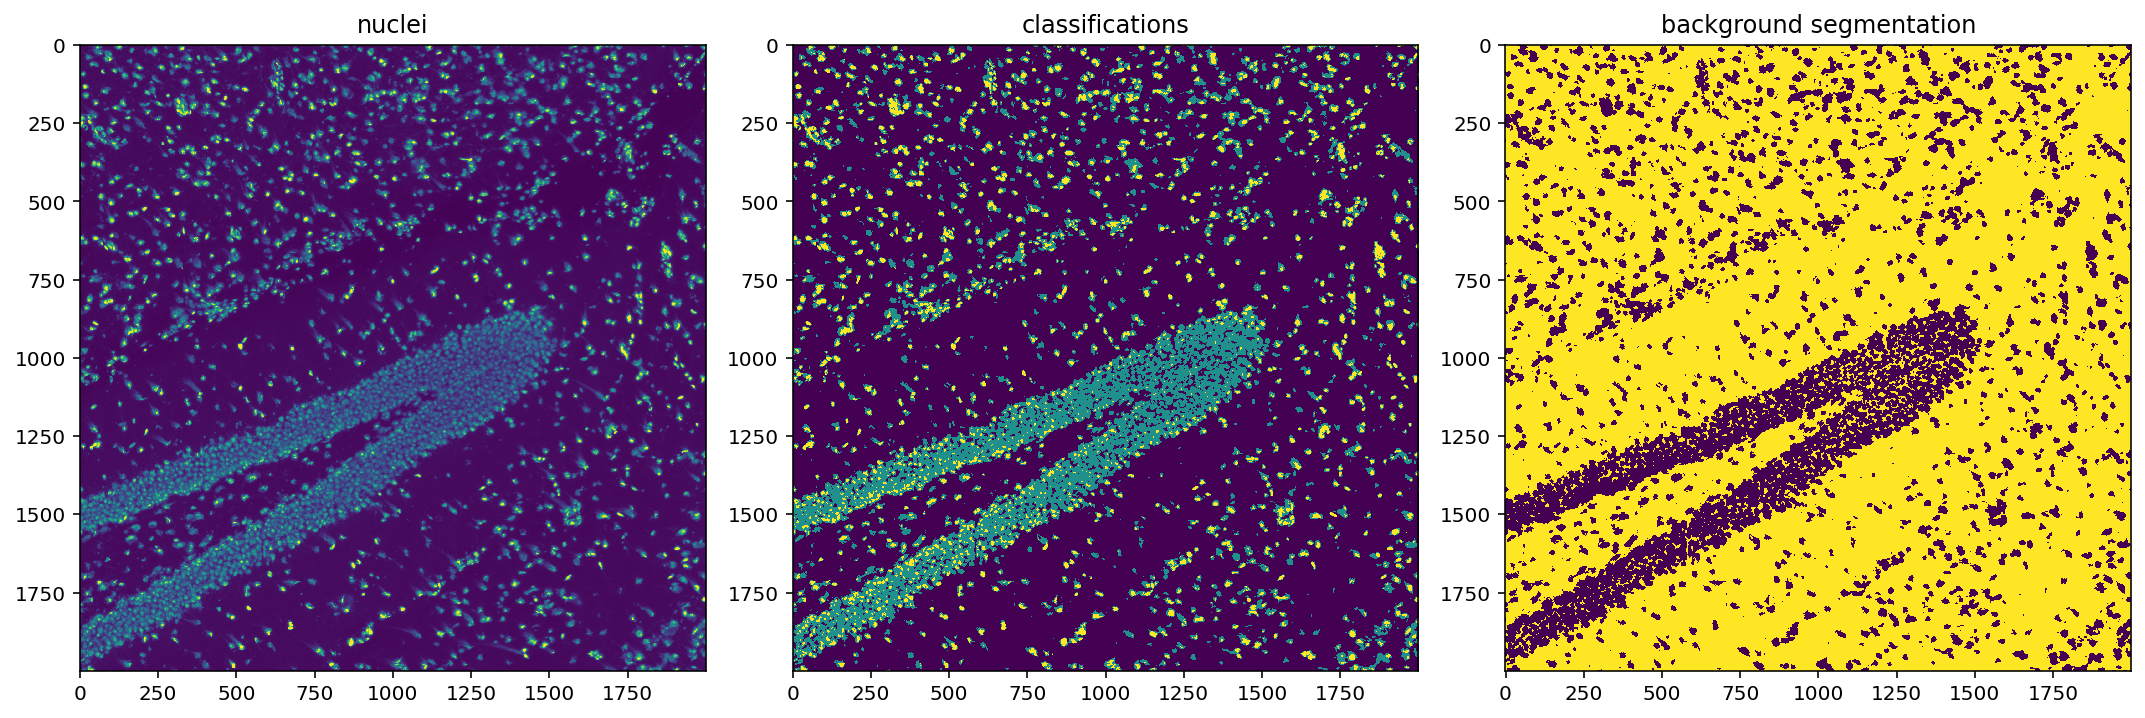

In [4]:
thresholds = skimage.filters.threshold_multiotsu(tif, 3)
regions = np.digitize(tif, bins=thresholds)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(regions)
axes[1].set_title('classifications')

background_mask = tif <= thresholds[0]
axes[2].imshow(background_mask)
axes[2].set_title('background segmentation')

Then, we separately apply a local (adaptive) thresholding method, which uses the local neighborhood of each pixel to determine the threshold for that pixel. This method is usually quite accurate (especially for images that have highly variable nuclei density), but becomes noisy in sparse areas.

Text(0.5, 1.0, 'local segmentation')

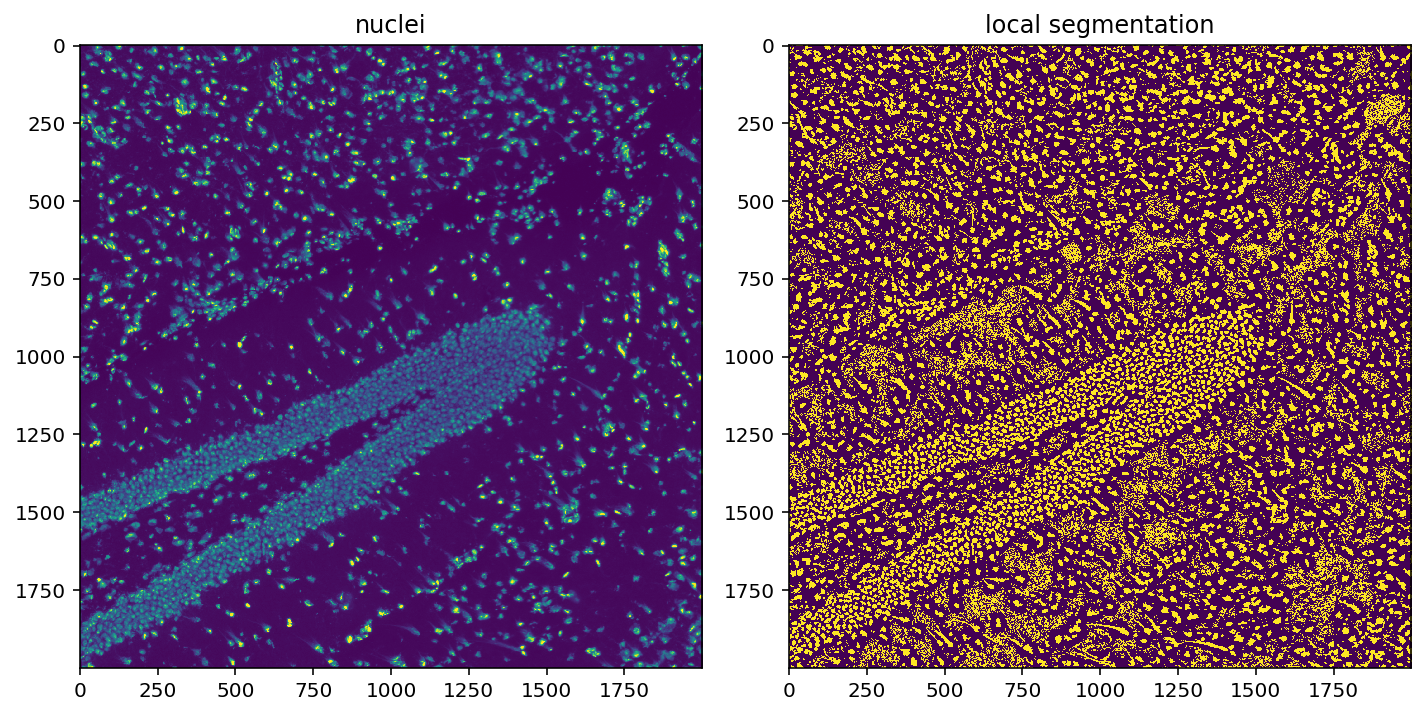

In [5]:
local_mask = tif > skimage.filters.threshold_local(tif, 45)
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(local_mask)
axes[1].set_title('local segmentation')

Now, we use both the background mask (obtained via global thresholding) and the cell mask (obtained via local thresholding) to obtain the final mask.

Text(0.5, 1.0, 'nuclei segmentation')

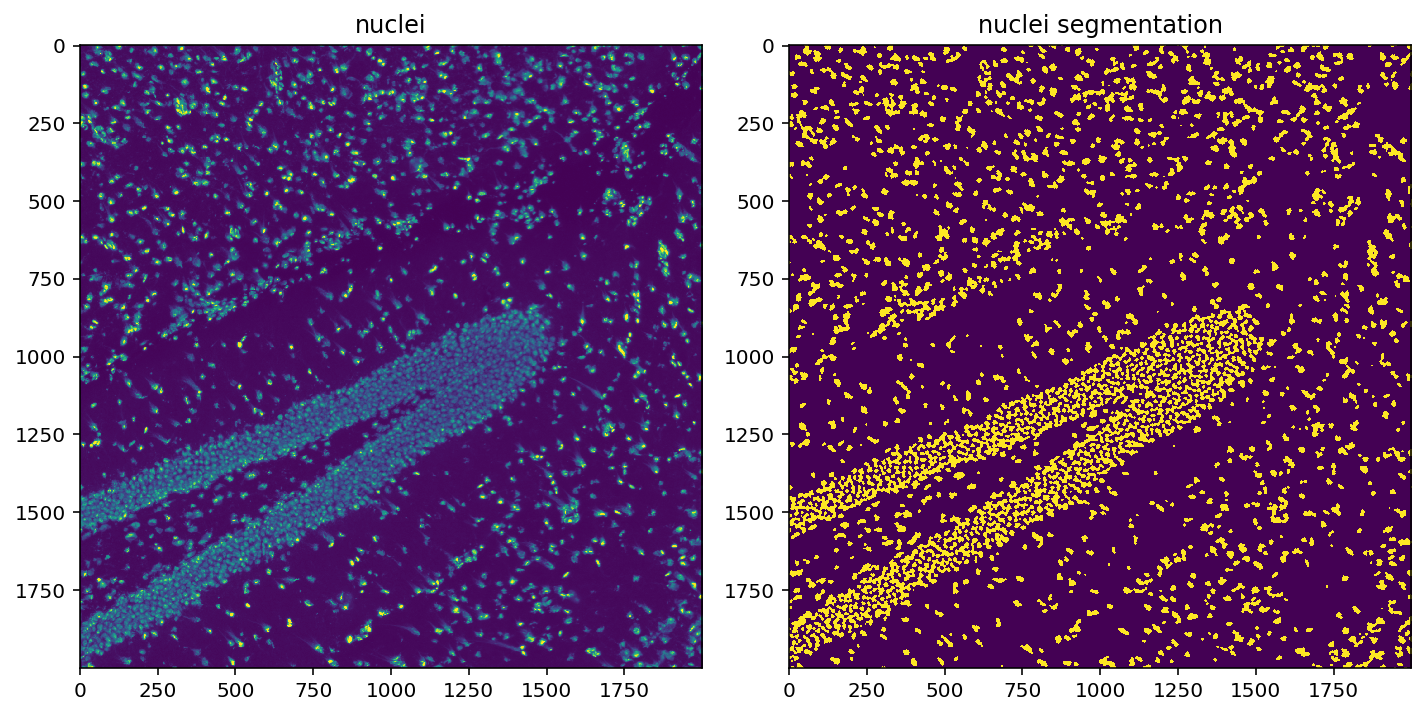

In [6]:
nuclei_mask = st.pp.segmentation.utils.mclose_mopen(
    (~background_mask) & local_mask, 7
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(nuclei_mask)
axes[1].set_title('nuclei segmentation')

The function `st.pp.segmentation.icell.mask_nuclei_from_stain` combines all the above procedures into a single function.

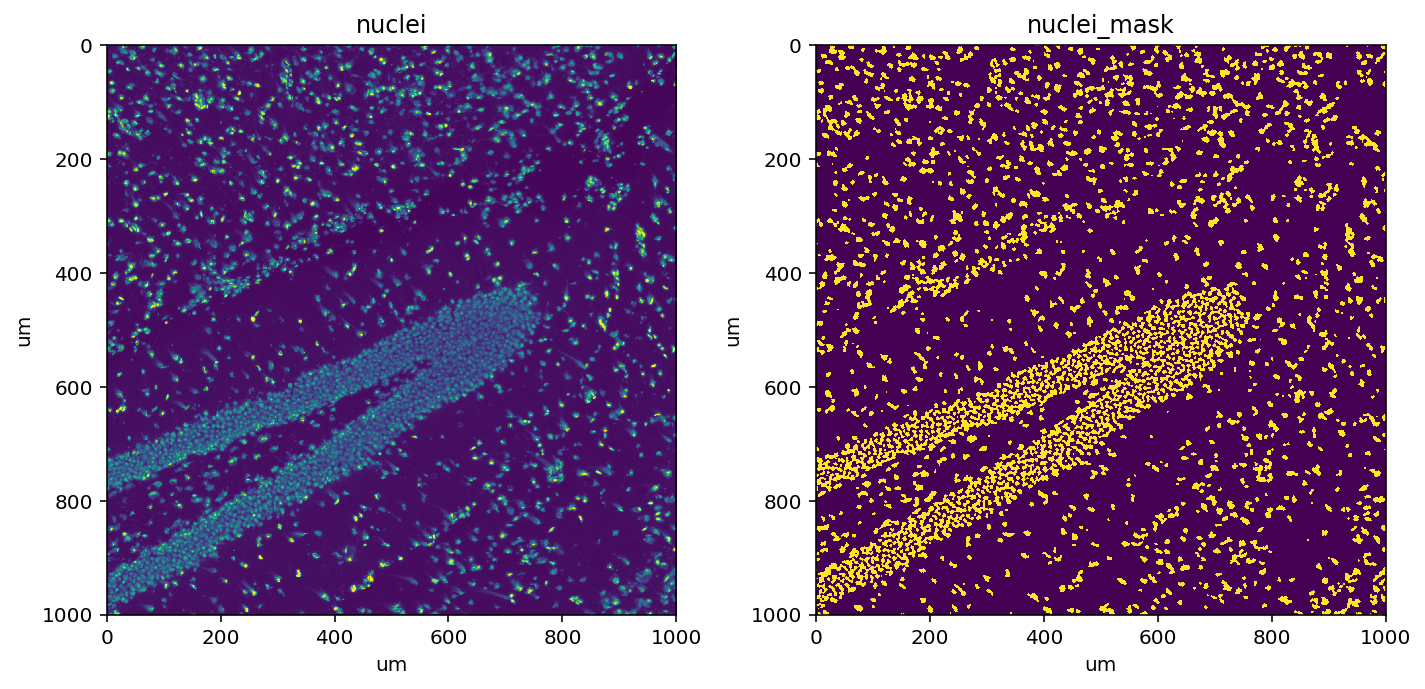

In [45]:
st.pp.segmentation.mask_nuclei_from_stain(
    adata, otsu_classes=3, otsu_index=0, local_k=45, mk=7
)
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclei', ax=axes[0])
st.pl.imshow(adata, 'nuclei_mask', ax=axes[1])

This does a pretty good job at identifying where nuclei are, but there are some noisy areas and regions where multiple nuclei are connected. We would like to separate individual nuclei. We can do so by using the Watershed algorithm. Note that this algorithm relies on a set of "markers" which will serve as seed regions for segmentation. Therefore, finding good markers is very important.

Here, we will use `st.pp.segmentation.utils.safe_erode`, which is a modification of the morphological erosion operation. Unlike the canonical operation, this function does not erode connected components that are less than the desired area. With these markers, we will apply the Watershed algorithm.

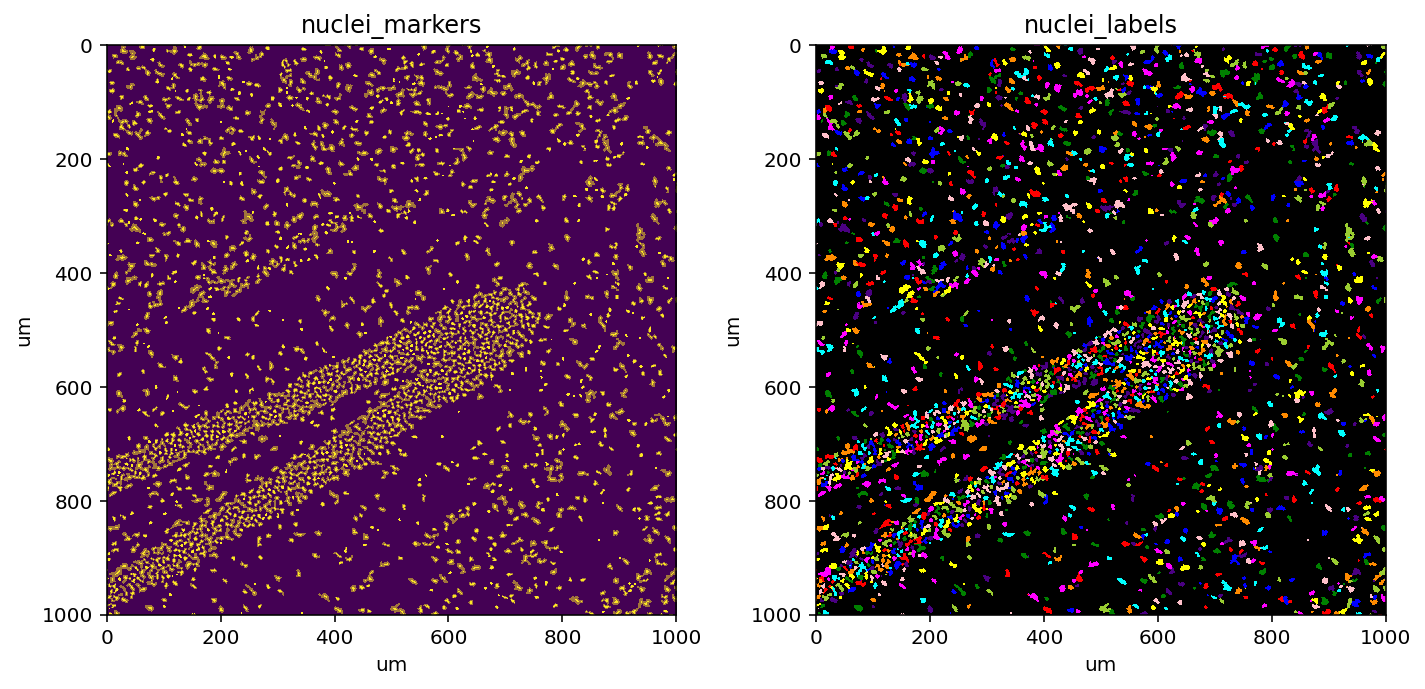

In [87]:
# We need to provide the original data layer name ('nuclei') here because these functions are also
# re-used during cell segmentation.
st.pp.segmentation.watershed_markers(adata, 'nuclei')
st.pp.segmentation.watershed(adata, 'nuclei')

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclei_mask', ax=axes[0])
st.pl.imshow(adata, 'nuclei_markers', ax=axes[0], alpha=0.5)

st.pl.imshow(adata, 'nuclei_labels', ax=axes[1], labels=True)

nuclei_labels = adata.layers['nuclei_labels'].copy()
nuclei_mask = nuclei_labels > 0

## Segmentation using (intronic) RNA signal

When stained nuclei are not available, it is possible to identify nuclei using intronic RNA. This approach, however, relies on the mis-priming of pre-processed intronic RNA onto the polyA nanoballs. Therefore, it is not reasonable to expect that we will be able to identify nearly as many nuclei as we did with the staining image due to overall low (intron) capture rate, technical and biological noise, and RNA diffusion.

In this part, we assume that we do not have access to the nuclei staining image. In the end, we will compare the results with the nuclei segmented using staining (above).

First, we will try and separate out regions that do not have nuclei, and regions that do. Observe that we apply the EM algorithm followed by belief propagation (`method='EM+BP'`), which gives us the propbability, at each pixel, that the pixel is occupied. Then, we find Otsu thresholds of these probabilities, assigning pixels into three bins. The pixels in the second and third bins will be used as an overall mask, whereas pixels in only the third bin will be used to identify markers for the Watershed algorithm.

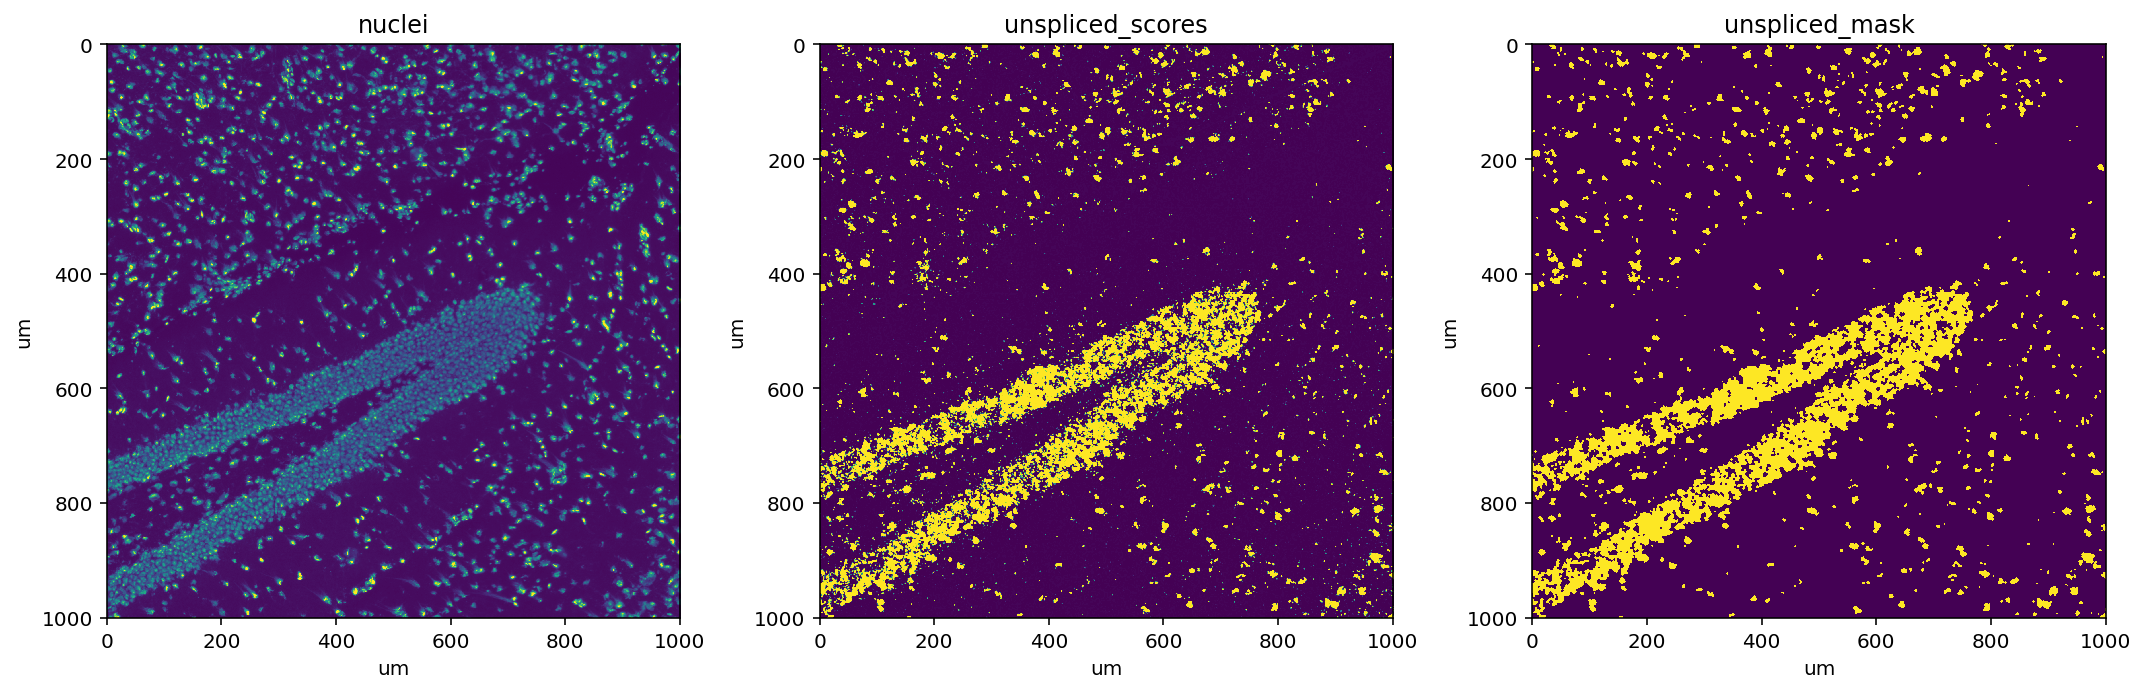

In [80]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=7, method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
    mk=7,
    bins_layer=False  # Ignore bins in case they exist
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclei', ax=axes[0])
st.pl.imshow(adata, 'unspliced_scores', ax=axes[1])
st.pl.imshow(adata, 'unspliced_mask', ax=axes[2])

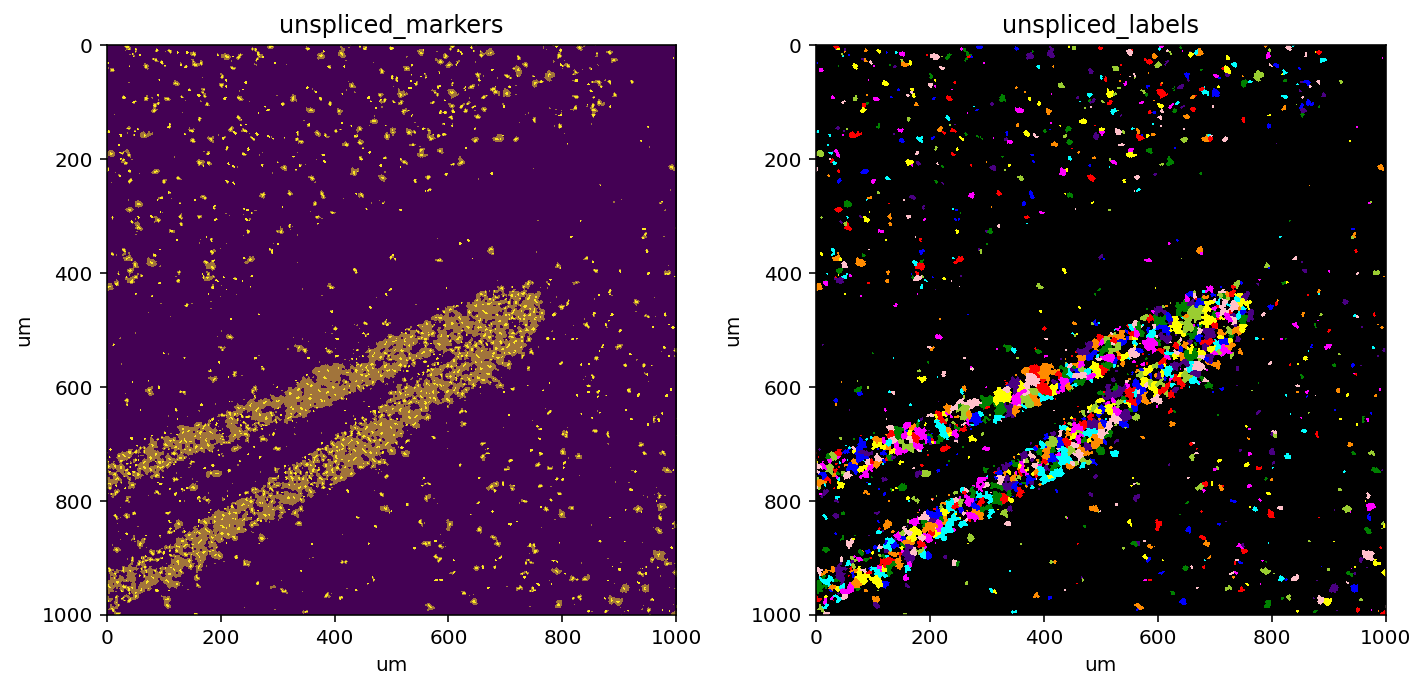

In [83]:
st.pp.segmentation.watershed_markers(adata, 'unspliced', n_iter=20)
st.pp.segmentation.watershed(adata, 'unspliced')

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced_mask', ax=axes[0])
st.pl.imshow(adata, 'unspliced_markers', ax=axes[0], alpha=0.5)

st.pl.imshow(adata, 'unspliced_labels', ax=axes[1], labels=True)

unspliced_labels = adata.layers['unspliced_labels'].copy()
unspliced_mask = unspliced_labels > 0

## Segmentation using (intronic) RNA signal with densities

Segmentation using purely RNA signal is sensitive to regions with varying RNA density. In other words, the procedure will usually be very lenient in RNA-dense regions (resulting in "blobs" of many cells) and strict in RNA-sparse regions (very few small regions). We can alleviate this problem by first dividing the pixels into clusters based on RNA density, and then performing nuclei segmentation on each cluster separately.

Note that the reason we perform binning is twofold -- first, we want to somewhat "smooth out" the UMI counts so that there is less noise from pixel to pixel, and second, to speed up computation.

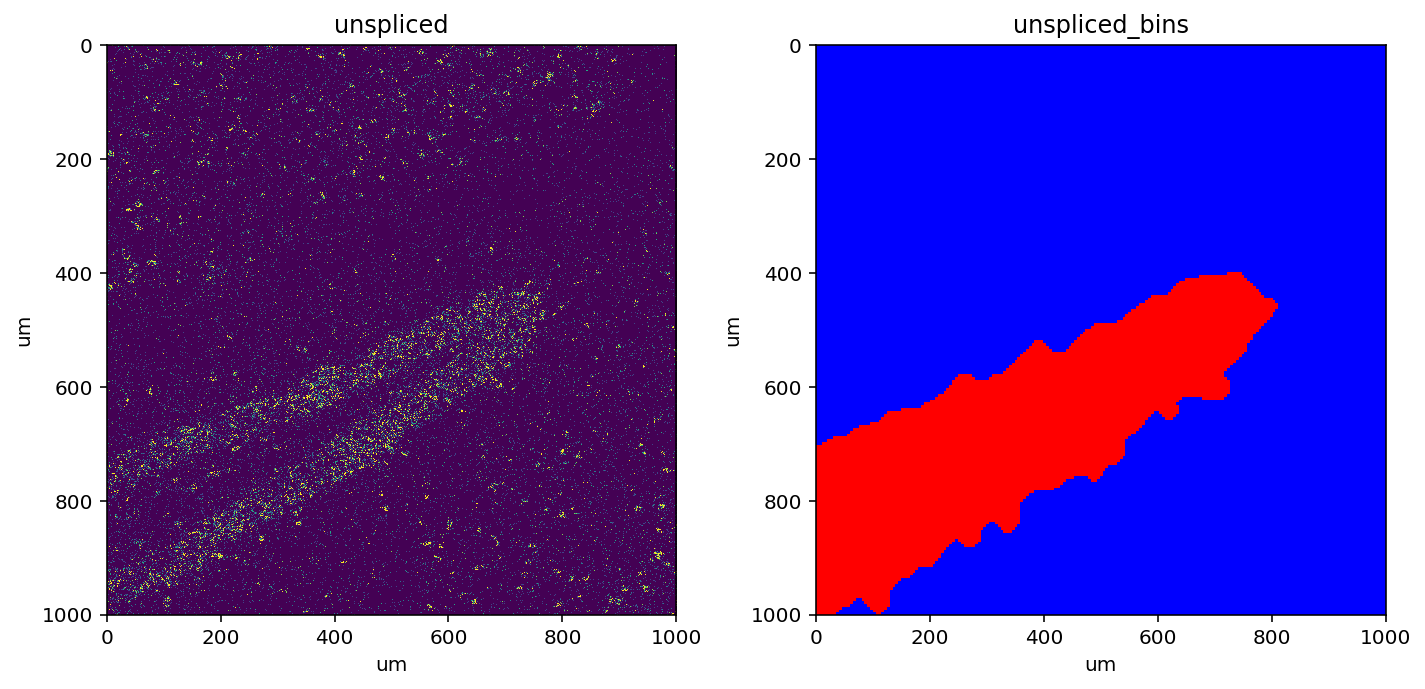

In [84]:
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=9, distance_threshold=5)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced', vmax=5, ax=axes[0])
st.pl.imshow(adata, 'unspliced_bins', ax=axes[1], labels=True)

We will now use these bins to segment cells within each bin separately.

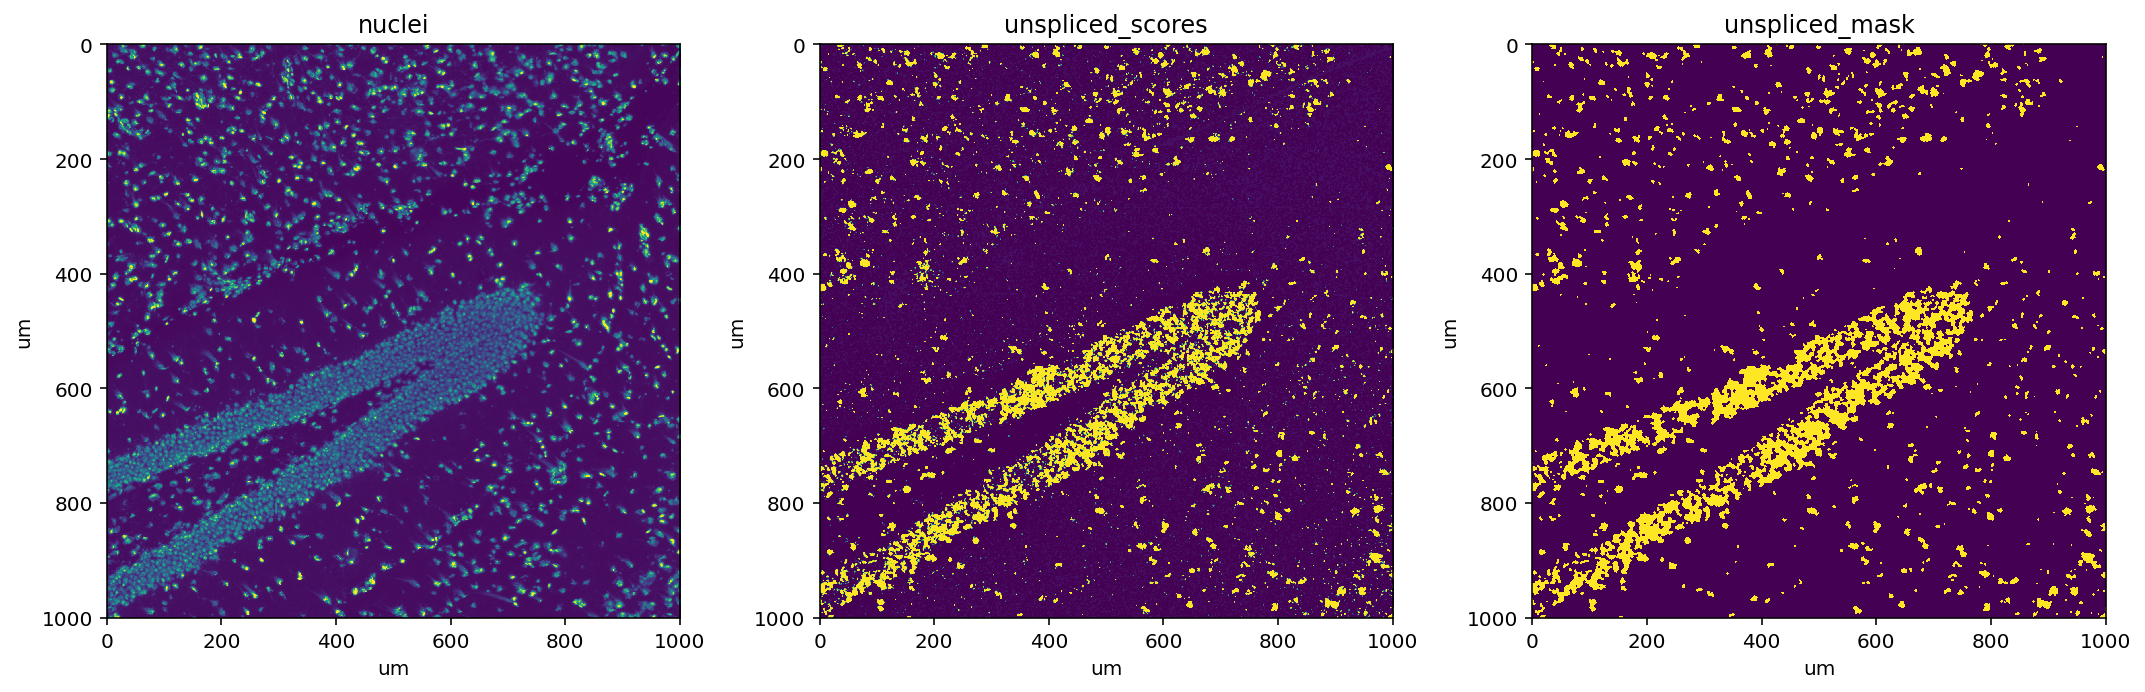

In [85]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=7, method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
    mk=7
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclei', ax=axes[0])
st.pl.imshow(adata, 'unspliced_scores', ax=axes[1])
st.pl.imshow(adata, 'unspliced_mask', ax=axes[2])

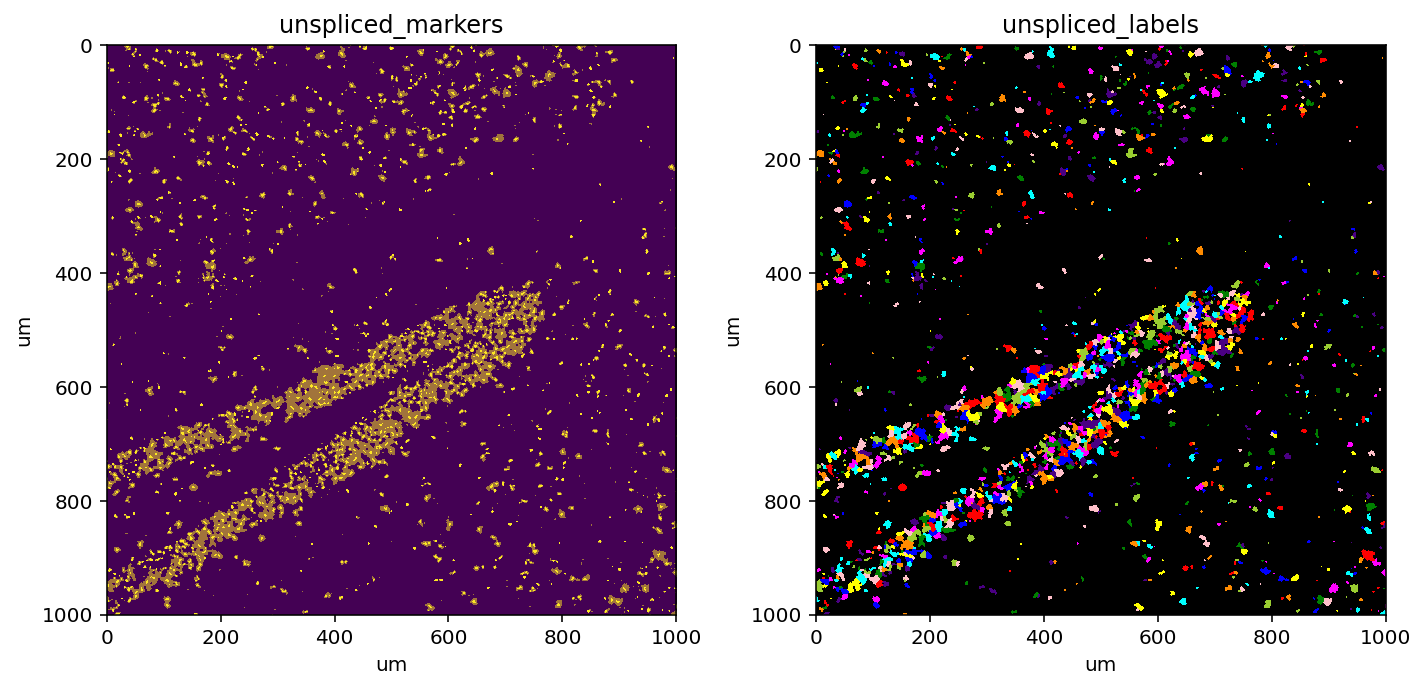

In [86]:
st.pp.segmentation.watershed_markers(adata, 'unspliced', n_iter=20)
st.pp.segmentation.watershed(adata, 'unspliced')

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced_mask', ax=axes[0])
st.pl.imshow(adata, 'unspliced_markers', ax=axes[0], alpha=0.5)

st.pl.imshow(adata, 'unspliced_labels', ax=axes[1], labels=True)

unspliced_density_labels = adata.layers['unspliced_labels'].copy()
unspliced_density_mask = unspliced_density_labels > 0

In [93]:
adata.write('data/nuclei_segmentation.h5ad', compression='gzip')

## Performance benchmarks

A key question is: how well does RNA-based nuclei segmentation perform? To answer this question, we will compare the nuclei segmentation done with staining against the RNA-based results.

Text(0.5, 1.0, 'RNA mask with density')

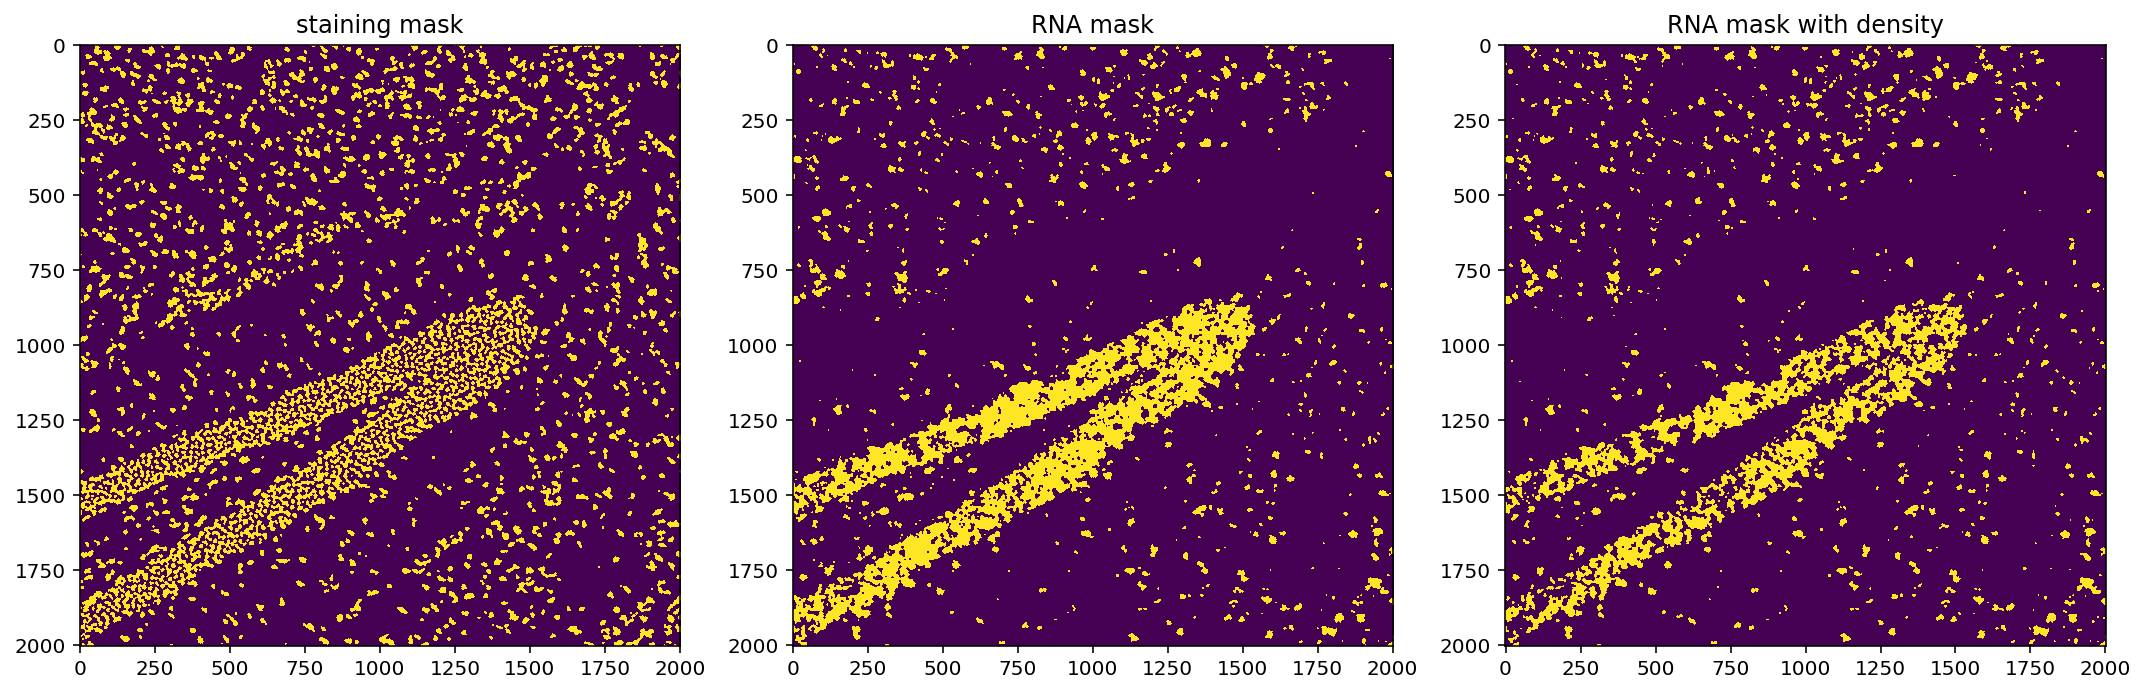

In [88]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)

axes[0].imshow(nuclei_mask)
axes[0].set_title('staining mask')
axes[1].imshow(unspliced_mask)
axes[1].set_title('RNA mask')
axes[2].imshow(unspliced_density_mask)
axes[2].set_title('RNA mask with density')

At the most basic level, we can compare the two masks by imagining this to be a classification task. These rates are a combination of multiple factors, ranging from the sensitivity of the assay itself (its ability to detect mRNA) to the correctness and robustness of the algorithm.

In [89]:
def compute_stats(y_true, y_pred):
    pos = y_true.sum()
    neg = (~y_true).sum()
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_pred).ravel()
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    return tn / neg, fp / neg, fn / pos, tp / pos, f1_score

tn, fp, fn, tp, f1 = compute_stats(nuclei_mask.flatten(), unspliced_mask.flatten())
print(f'RNA mask stats ---------')
print(f'True negative: {tn:.3f}')
print(f'False positive: {fp:.3f}')
print(f'False negative: {fn:.3f}')
print(f'True positive: {tp:.3f}')
print(f'F1 score: {f1:.3f}')

tn, fp, fn, tp, f1 = compute_stats(nuclei_mask.flatten(), unspliced_density_mask.flatten())
print(f'\nRNA mask with density stats ---------')
print(f'True negative: {tn:.3f}')
print(f'False positive: {fp:.3f}')
print(f'False negative: {fn:.3f}')
print(f'True positive: {tp:.3f}')
print(f'F1 score: {f1:.3f}')

RNA mask stats ---------
True negative: 0.920
False positive: 0.080
False negative: 0.685
True positive: 0.315
F1 score: 0.364

RNA mask with density stats ---------
True negative: 0.930
False positive: 0.070
False negative: 0.741
True positive: 0.259
F1 score: 0.319


One important observation is that the RNA segmentation using densities seems to perform poorer than without densities in terms of false negative rates (i.e. the false negative rate is higher). In other words, the using densities results in more conservative segmentations. For this particular sample, this is because the algorithm becomes more strict in the nuclei-dense region in the center.

In the following sections, we will focus on specific areas that affect the above rates.

First is the dropout rate: how many nuclei we are unable to detect, most likely due to the sensitivity of the assay itself. This can be calculated by counting how many nuclei at least some percent covered by our RNA-based nuclei mask.

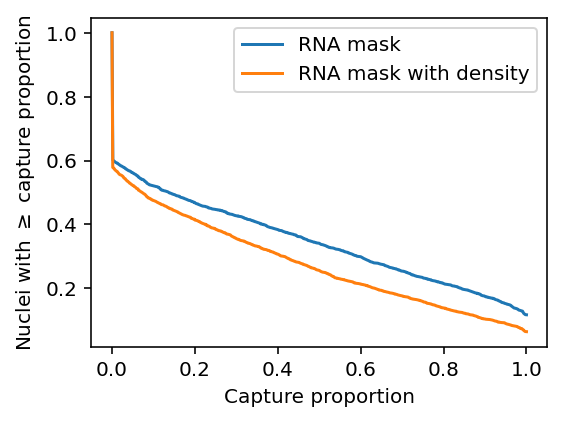

In [90]:
def capture_proportions(watershed, est_mask):
    labels = np.unique(watershed)[1:]
    props = []
    for label in labels:
        label_mask = watershed == label
        area = label_mask.sum()

        intersect = label_mask & est_mask
        intersect_area = intersect.sum()

        props.append(intersect_area / area)

    return np.unique(props, return_counts=True)

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
unique, counts = capture_proportions(adata.layers['nuclei_labels'], unspliced_mask)
ax.plot(unique, np.cumsum(counts[::-1])[::-1] / counts.sum(), label='RNA mask')
ax.set_xlabel('Capture proportion')
ax.set_ylabel('Nuclei with $\geq$ capture proportion')

unique, counts = capture_proportions(adata.layers['nuclei_labels'], unspliced_density_mask)
ax.plot(unique, np.cumsum(counts[::-1])[::-1] / counts.sum(), label='RNA mask with density')
ax.legend()

How about the nuclei labeling itself? Can we accurately assign each individual captured nucleus? We will now compare the consistency of the labeling.

Text(0.5, 1.0, 'RNA labels with density')

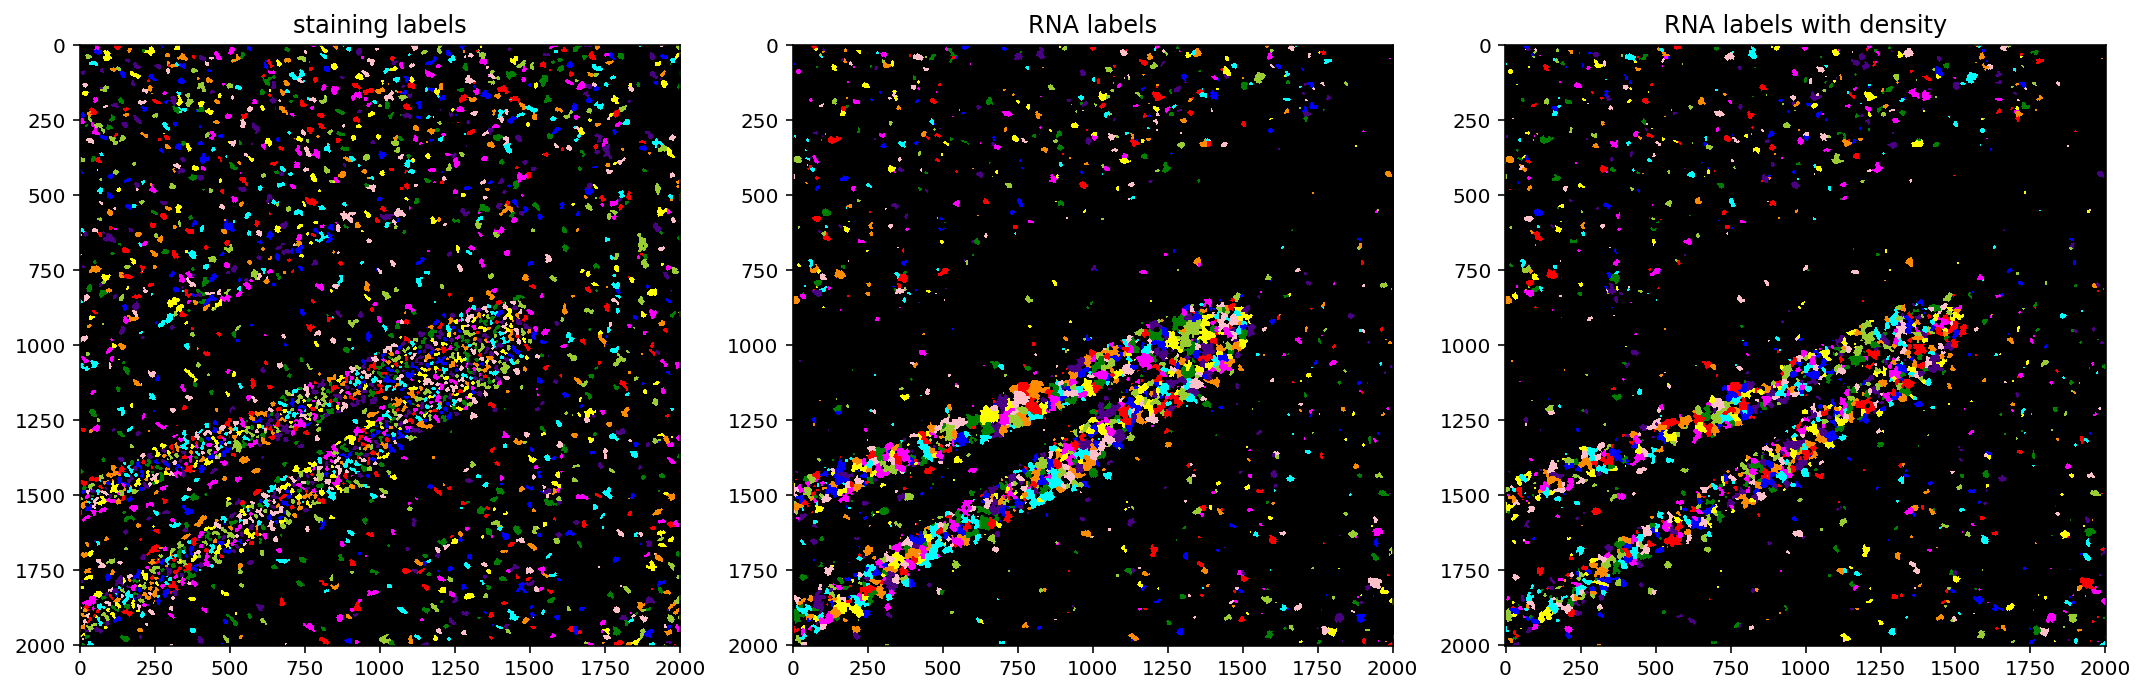

In [91]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)

axes[0].imshow(skimage.color.label2rgb(nuclei_labels))
axes[0].set_title('staining labels')

axes[1].imshow(skimage.color.label2rgb(unspliced_labels))
axes[1].set_title('RNA labels')

axes[2].imshow(skimage.color.label2rgb(unspliced_density_labels))
axes[2].set_title('RNA labels with density')

Since we already calculated the false positive and false negative rates above, we will only focus on pixels that are occupied in both masks.

Text(0.5, 1.0, 'w/ density ARS = 0.596')

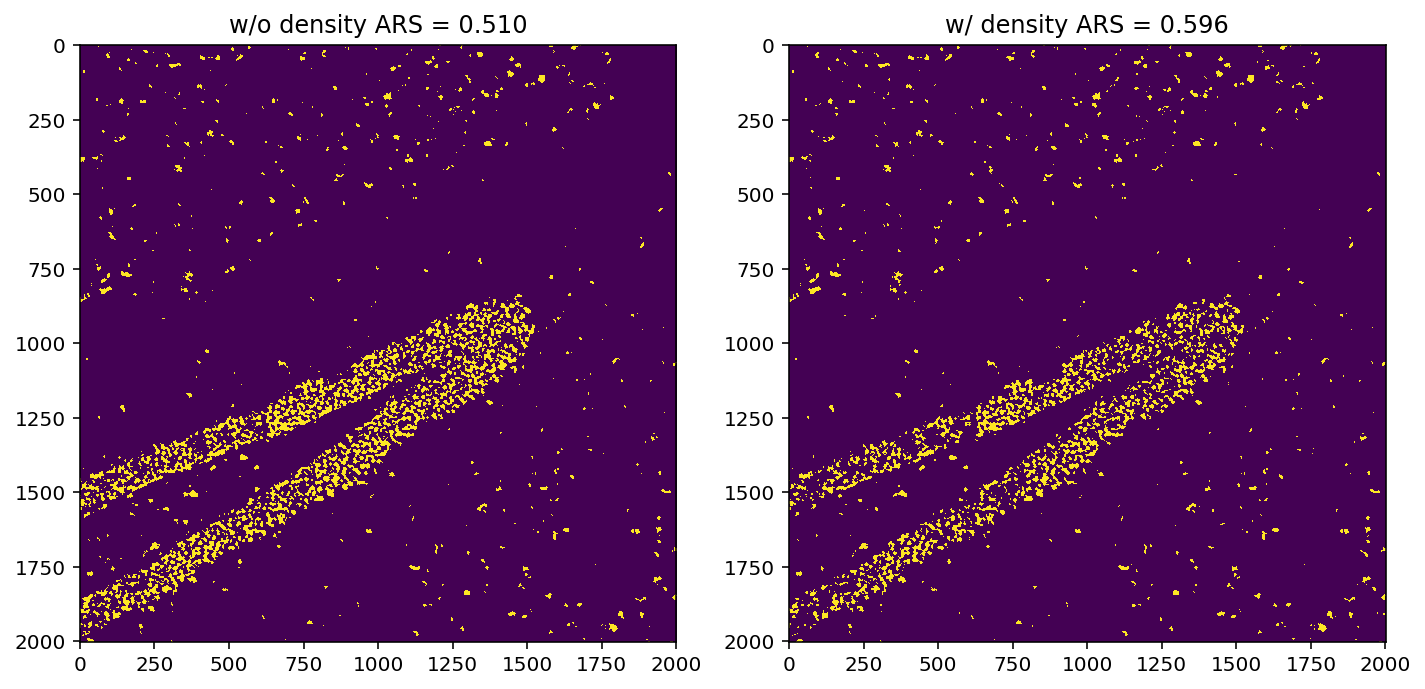

In [92]:
mask = (nuclei_mask & unspliced_mask)
ars = sklearn.metrics.adjusted_rand_score(
    nuclei_labels.flatten()[mask.flatten()],
    unspliced_labels.flatten()[mask.flatten()]
)
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
axes[0].imshow(mask)
axes[0].set_title(f'w/o density ARS = {ars:.3f}')

mask = (nuclei_mask & unspliced_density_mask)
ars = sklearn.metrics.adjusted_rand_score(
    nuclei_labels.flatten()[mask.flatten()],
    unspliced_density_labels.flatten()[mask.flatten()]
)
axes[1].imshow(mask)
axes[1].set_title(f'w/ density ARS = {ars:.3f}')

We observe that using RNA densities yields more correct nuclei labels as compared with the staining results. In other words, there is a tradeoff between sensitivity (how many pixels can be accurately called as being occupied by a nucleus) and accuracy (how many pixels were accurately assigned to the same nucleus).